In [2]:
from sklearn.model_selection import train_test_split
from glob import glob
import torch
import random
import pandas as pd
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler
import numpy as np

In [4]:
from torch.utils.data import Dataset, DataLoader

In [ ]:

# Dataset Definition
class BatteryDataset(Dataset):
    def __init__(self, pkl_paths, scaler=None, fit_scaler=False): #scaler 받아서 test set 은 train.scheduler 로 학습
        self.paths = pkl_paths
        self.scaler = scaler or StandardScaler()

        if fit_scaler:
            all_data = []
            for path in self.paths:
                data = torch.load(path, weights_only=False)[0]
                data = data[:, :-1]  # 마지막 열(timestamp) 제거
                all_data.append(data)
            all_data = np.concatenate(all_data, axis=0)
            self.scaler.fit(all_data)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        data = torch.load(path, weights_only=False)
        x = data[0][:, :-1] 
        x = self.scaler.transform(x)
        x = torch.tensor(x, dtype=torch.float32)

        label_raw = float(data[1]['label'])
        label = 1.0 if label_raw == 10.0 else 0.0 # 1라벨이 10으로 표기되어있어 1로 고쳐주는 코드
        y = torch.tensor(label, dtype=torch.float32)

        return x, y

In [ ]:
#기존 데이터셋이 이미 train/test 로 나누어져 있어서 그대로 불러옴
all_paths = glob('./dataset/battery_brand2/train/*.pkl') + glob('./dataset/battery_brand2/test/*.pkl')


labels = [int(torch.load(p)[1]['label']) for p in all_paths]

# 시드 고정
random.seed(42)

#기존 dataset 은 6: 4 로 되어있어 불러와서 다시 나눔 
# train:test = 8:2 분할
#이때 stratify 를 적용함
train_paths, test_paths = train_test_split(
    all_paths,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

#  pos_weight 계산 (훈련 데이터 기준)
train_labels = [int(torch.load(p)[1]['label']) for p in train_paths]
normal_count = train_labels.count(0)
abnormal_count = train_labels.count(10)
pos_weight = torch.tensor([normal_count / abnormal_count])



train_dataset = BatteryDataset(train_paths, fit_scaler=True)
test_dataset = BatteryDataset(test_paths, scaler=train_dataset.scaler)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=2048, pin_memory=True)

/tmp/ipykernel_3271318/501609925.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = [int(torch.load(p)[1]['label']) for p in all_paths]
/tmp/ipykernel_3271318/5016

In [ ]:
import torch
import pandas as pd

# 샘플 데이터 하나 확인
sample_path = train_paths[0] 
data = torch.load(sample_path)


df = pd.DataFrame(data[0])


print("열 이름:", df.columns.tolist())
print("shape:", df.shape)
print(df.head())


열 이름: [0, 1, 2, 3, 4, 5, 6, 7]
shape: (128, 8)
         0     1        2         3         4     5     6     7
0  3.16525 -16.0  64.0000  3.835938  3.750000  37.0  34.0   0.0
1  3.16725 -16.0  64.0000  3.835938  3.750000  37.0  34.0  10.0
2  3.16550 -16.0  64.0375  3.835938  3.750000  37.0  34.0  20.0
3  3.16975 -16.0  64.3750  3.835938  3.750195  37.0  34.0  30.0
4  3.16750 -16.0  64.3750  3.836133  3.751953  37.0  34.0  40.0


/tmp/ipykernel_3271318/1980778153.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(sample_path)


In [ ]:
# 샘플 데이터 하나 확인
sample_path = train_paths[1] 
data = torch.load(sample_path)


df = pd.DataFrame(data[0])


print("열 이름:", df.columns.tolist())
print("shape:", df.shape)
print(df.head())


열 이름: [0, 1, 2, 3, 4, 5, 6, 7]
shape: (128, 8)
       0    1       2         3         4     5     6     7
0  3.505  0.0  91.625  4.191406  4.175781  45.0  41.0   0.0
1  3.505  0.0  91.625  4.191406  4.175781  45.0  41.0  10.0
2  3.505  0.0  91.625  4.191406  4.175781  45.0  41.0  20.0
3  3.505  0.0  91.625  4.191406  4.175781  45.0  41.0  30.0
4  3.505  0.0  91.625  4.191406  4.175781  45.0  41.0  40.0


/tmp/ipykernel_3271318/1656621042.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(sample_path)


In [21]:
pos_weight 

tensor([0.7454])

In [ ]:
import torch.nn as nn
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim=7, hidden_dim=64, num_layers=2):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  
        return out.squeeze(1)


In [ ]:
#model, cirterion, optimizer,scheduler 선언 
#epoch 30으로 설정 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMClassifier().to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

num_epochs = 30
loss_history = []

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# y 값 10 -> 1로 잘 변환 되었는지 확인
X_batch, y_batch = next(iter(train_loader))
print("y 라벨 샘플:", y_batch[:10])
print("y 데이터 타입:", y_batch.dtype)
print("y 고유 값들:", y_batch.unique())

y 라벨 샘플: tensor([0., 0., 1., 1., 1., 1., 1., 1., 1., 0.])
y 데이터 타입: torch.float32
y 고유 값들: tensor([0., 1.])


In [13]:
from tqdm import tqdm 

In [ ]:
#train set 학습 시키는 코드
# 따로 val set 을 두지않고 train set 으로 val set 을 둠

from sklearn.metrics import accuracy_score

train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_loss = 0
    all_preds = []
    all_labels = []

    for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X).to(device)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * X.size(0)

        preds = torch.sigmoid(logits) > 0.8
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(y.detach().cpu().numpy())

    avg_loss = epoch_loss / len(train_loader.dataset)
    train_acc = accuracy_score(all_labels, all_preds)
    train_loss_history.append(avg_loss)
    train_acc_history.append(train_acc)

    scheduler.step(avg_loss)

    model.eval() # validation
    test_loss = 0
    test_preds = []
    test_labels = []

    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            logits_test = model(X_test)
            loss_test = criterion(logits_test, y_test)
            test_loss += loss_test.item() * X_test.size(0)

            preds_test = (torch.sigmoid(logits_test) > 0.8).float()
            test_preds.extend(preds_test.cpu().numpy())
            test_labels.extend(y_test.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader.dataset)
    test_acc = accuracy_score(test_labels, test_preds)
    test_loss_history.append(avg_test_loss)
    test_acc_history.append(test_acc)

    print(f"[Epoch {epoch+1:02d}] Train Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f} || Test Loss: {avg_test_loss:.4f} | Test Acc: {test_acc:.4f}")


  3%|▎         | 1/30 [01:11<34:23, 71.16s/it]

[Epoch 01] Train Loss: 0.3549 | Train Acc: 0.6993 || Test Loss: 0.2914 | Test Acc: 0.7074


  7%|▋         | 2/30 [02:21<33:04, 70.89s/it]

[Epoch 02] Train Loss: 0.2695 | Train Acc: 0.8124 || Test Loss: 0.2480 | Test Acc: 0.8661


 10%|█         | 3/30 [03:33<32:07, 71.39s/it]

[Epoch 03] Train Loss: 0.2509 | Train Acc: 0.8289 || Test Loss: 0.2284 | Test Acc: 0.8669


 13%|█▎        | 4/30 [04:44<30:49, 71.15s/it]

[Epoch 04] Train Loss: 0.2153 | Train Acc: 0.8576 || Test Loss: 0.1838 | Test Acc: 0.8657


 17%|█▋        | 5/30 [05:54<29:27, 70.69s/it]

[Epoch 05] Train Loss: 0.2290 | Train Acc: 0.8428 || Test Loss: 0.2575 | Test Acc: 0.8077


 20%|██        | 6/30 [07:06<28:23, 70.99s/it]

[Epoch 06] Train Loss: 0.2151 | Train Acc: 0.8586 || Test Loss: 0.2099 | Test Acc: 0.8587


 23%|██▎       | 7/30 [08:17<27:17, 71.18s/it]

[Epoch 07] Train Loss: 0.1919 | Train Acc: 0.8721 || Test Loss: 0.2031 | Test Acc: 0.8715


 27%|██▋       | 8/30 [09:29<26:11, 71.42s/it]

[Epoch 08] Train Loss: 0.1949 | Train Acc: 0.8698 || Test Loss: 0.1951 | Test Acc: 0.9040


 30%|███       | 9/30 [10:40<24:58, 71.36s/it]

[Epoch 09] Train Loss: 0.1768 | Train Acc: 0.8814 || Test Loss: 0.1579 | Test Acc: 0.9057


 33%|███▎      | 10/30 [11:53<23:55, 71.78s/it]

[Epoch 10] Train Loss: 0.1699 | Train Acc: 0.8922 || Test Loss: 0.1511 | Test Acc: 0.8937


 37%|███▋      | 11/30 [13:04<22:37, 71.45s/it]

[Epoch 11] Train Loss: 0.1792 | Train Acc: 0.8842 || Test Loss: 0.1763 | Test Acc: 0.8941


 40%|████      | 12/30 [14:15<21:23, 71.31s/it]

[Epoch 12] Train Loss: 0.1645 | Train Acc: 0.8974 || Test Loss: 0.1510 | Test Acc: 0.8939


 43%|████▎     | 13/30 [15:26<20:10, 71.23s/it]

[Epoch 13] Train Loss: 0.1667 | Train Acc: 0.8900 || Test Loss: 0.1742 | Test Acc: 0.8772


 47%|████▋     | 14/30 [16:36<18:55, 70.96s/it]

[Epoch 14] Train Loss: 0.1473 | Train Acc: 0.9071 || Test Loss: 0.1385 | Test Acc: 0.9208


 50%|█████     | 15/30 [17:46<17:40, 70.72s/it]

[Epoch 15] Train Loss: 0.1392 | Train Acc: 0.9159 || Test Loss: 0.1460 | Test Acc: 0.9243


 53%|█████▎    | 16/30 [18:56<16:26, 70.46s/it]

[Epoch 16] Train Loss: 0.1256 | Train Acc: 0.9264 || Test Loss: 0.1296 | Test Acc: 0.9337


 57%|█████▋    | 17/30 [20:06<15:13, 70.30s/it]

[Epoch 17] Train Loss: 0.1355 | Train Acc: 0.9208 || Test Loss: 0.1634 | Test Acc: 0.8802


 60%|██████    | 18/30 [21:16<14:02, 70.22s/it]

[Epoch 18] Train Loss: 0.1418 | Train Acc: 0.9167 || Test Loss: 0.1238 | Test Acc: 0.9242


 63%|██████▎   | 19/30 [22:29<13:00, 70.94s/it]

[Epoch 19] Train Loss: 0.1443 | Train Acc: 0.9131 || Test Loss: 0.1901 | Test Acc: 0.8797


 67%|██████▋   | 20/30 [23:40<11:51, 71.13s/it]

[Epoch 20] Train Loss: 0.1388 | Train Acc: 0.9149 || Test Loss: 0.1273 | Test Acc: 0.9253


 70%|███████   | 21/30 [24:52<10:43, 71.46s/it]

[Epoch 21] Train Loss: 0.1135 | Train Acc: 0.9319 || Test Loss: 0.1286 | Test Acc: 0.9346


 73%|███████▎  | 22/30 [26:05<09:34, 71.82s/it]

[Epoch 22] Train Loss: 0.1179 | Train Acc: 0.9304 || Test Loss: 0.1107 | Test Acc: 0.9324


 77%|███████▋  | 23/30 [27:18<08:24, 72.06s/it]

[Epoch 23] Train Loss: 0.1102 | Train Acc: 0.9331 || Test Loss: 0.1135 | Test Acc: 0.9394


 80%|████████  | 24/30 [28:29<07:10, 71.83s/it]

[Epoch 24] Train Loss: 0.1023 | Train Acc: 0.9423 || Test Loss: 0.1099 | Test Acc: 0.9473


 83%|████████▎ | 25/30 [29:42<06:00, 72.02s/it]

[Epoch 25] Train Loss: 0.1257 | Train Acc: 0.9256 || Test Loss: 0.1081 | Test Acc: 0.9324


 87%|████████▋ | 26/30 [30:52<04:45, 71.44s/it]

[Epoch 26] Train Loss: 0.1323 | Train Acc: 0.9262 || Test Loss: 0.1251 | Test Acc: 0.9308


 90%|█████████ | 27/30 [32:02<03:33, 71.27s/it]

[Epoch 27] Train Loss: 0.1068 | Train Acc: 0.9341 || Test Loss: 0.0975 | Test Acc: 0.9307


 93%|█████████▎| 28/30 [33:13<02:21, 70.91s/it]

[Epoch 28] Train Loss: 0.1073 | Train Acc: 0.9415 || Test Loss: 0.6425 | Test Acc: 0.7877


 97%|█████████▋| 29/30 [34:24<01:11, 71.02s/it]

[Epoch 29] Train Loss: 0.2218 | Train Acc: 0.8635 || Test Loss: 0.1482 | Test Acc: 0.9058


100%|██████████| 30/30 [35:34<00:00, 71.15s/it]

[Epoch 30] Train Loss: 0.1282 | Train Acc: 0.9219 || Test Loss: 0.1221 | Test Acc: 0.9284


In [29]:
import matplotlib.pyplot as plt

In [ ]:
from matplotlib import rcParams as rc
#plt 전역 변수 설정  
plt.rc('font', size=20)
plt.rcParams["figure.figsize"] = (8,8)



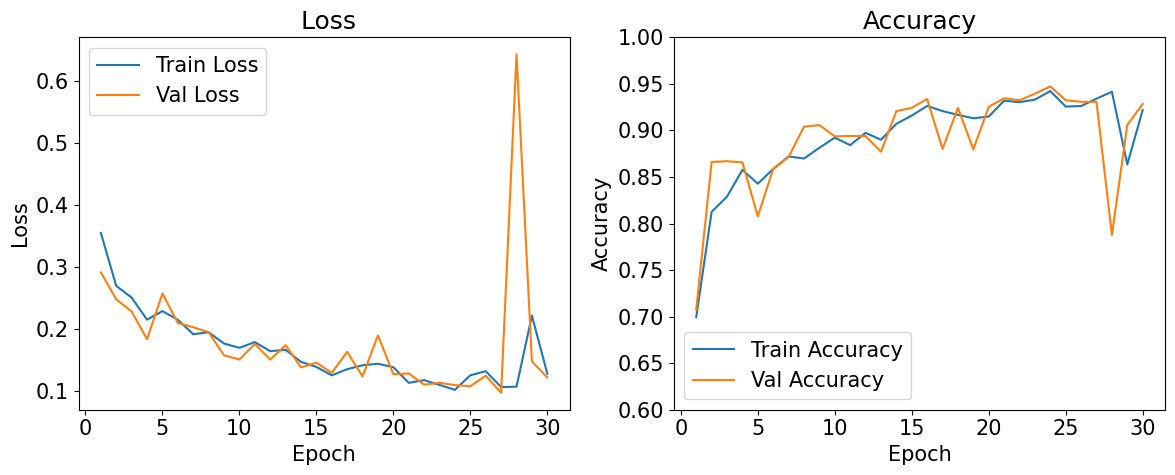

In [50]:

epochs = list(range(1, 31))

# Loss 그래프
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, label='Train Loss')
plt.plot(epochs, test_loss_history, label='Val Loss')
plt.xlabel('Epoch')

plt.ylabel('Loss')
plt.title(' Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_history, label='Train Accuracy')
plt.plot(epochs, test_acc_history, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.yticks(np.arange(0.6,1.01, 0.05))
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

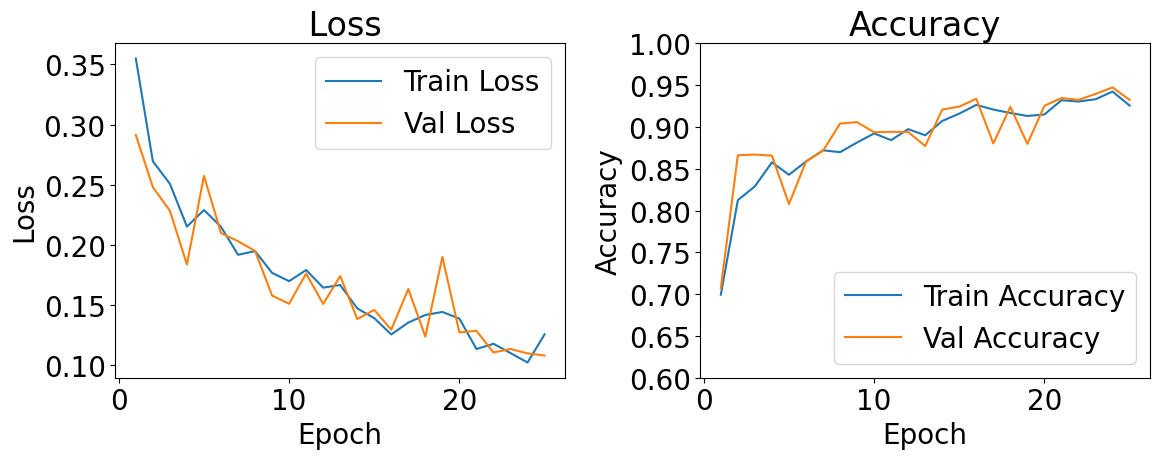

In [ ]:
# 에포크 범위 설정 (25까지가 적당, 30부턴 overfitting)
train_loss_history_25 = train_loss_history[:25]
test_loss_history_25 = test_loss_history[:25]
train_acc_history_25 = train_acc_history[:25]
test_acc_history_25 = test_acc_history[:25]
epochs = list(range(1, 26))

# Loss 그래프
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history_25, label='Train Loss')
plt.plot(epochs, test_loss_history_25, label='Val Loss')
plt.xlabel('Epoch')

plt.ylabel('Loss')
plt.title(' Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_history_25, label='Train Accuracy')
plt.plot(epochs, test_acc_history_25, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.yticks(np.arange(0.6,1.01, 0.05))
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [51]:
#에포트 25까지로 다시 학습
#model, cirterion, optimizer,scheduler 선언 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMClassifier().to(device) #model 초기화
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

num_epochs = 25
loss_history = []

#train set 학습 시키는 코드
# 따로 val set 을 두지않고 train set 으로 val set 을 둠

from sklearn.metrics import accuracy_score

train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_loss = 0
    all_preds = []
    all_labels = []

    for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X).to(device)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * X.size(0)

        preds = torch.sigmoid(logits) > 0.8
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(y.detach().cpu().numpy())

    avg_loss = epoch_loss / len(train_loader.dataset)
    train_acc = accuracy_score(all_labels, all_preds)
    train_loss_history.append(avg_loss)
    train_acc_history.append(train_acc)

    scheduler.step(avg_loss)

    model.eval() # validation
    test_loss = 0
    test_preds = []
    test_labels = []

    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            logits_test = model(X_test)
            loss_test = criterion(logits_test, y_test)
            test_loss += loss_test.item() * X_test.size(0)

            preds_test = (torch.sigmoid(logits_test) > 0.8).float()
            test_preds.extend(preds_test.cpu().numpy())
            test_labels.extend(y_test.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader.dataset)
    test_acc = accuracy_score(test_labels, test_preds)
    test_loss_history.append(avg_test_loss)
    test_acc_history.append(test_acc)

    print(f"[Epoch {epoch+1:02d}] Train Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f} || Test Loss: {avg_test_loss:.4f} | Test Acc: {test_acc:.4f}")


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
  4%|▍         | 1/25 [01:09<27:43, 69.32s/it]

[Epoch 01] Train Loss: 0.4008 | Train Acc: 0.6428 || Test Loss: 0.3007 | Test Acc: 0.7965


  8%|▊         | 2/25 [02:18<26:31, 69.18s/it]

[Epoch 02] Train Loss: 0.2810 | Train Acc: 0.7991 || Test Loss: 0.2701 | Test Acc: 0.8544


 12%|█▏        | 3/25 [03:26<25:06, 68.50s/it]

[Epoch 03] Train Loss: 0.2403 | Train Acc: 0.8431 || Test Loss: 0.2348 | Test Acc: 0.8650


 16%|█▌        | 4/25 [04:35<24:09, 69.01s/it]

[Epoch 04] Train Loss: 0.2315 | Train Acc: 0.8426 || Test Loss: 0.2028 | Test Acc: 0.8724


 20%|██        | 5/25 [05:44<22:53, 68.69s/it]

[Epoch 05] Train Loss: 0.2075 | Train Acc: 0.8599 || Test Loss: 0.2537 | Test Acc: 0.8752


 24%|██▍       | 6/25 [06:52<21:45, 68.72s/it]

[Epoch 06] Train Loss: 0.2342 | Train Acc: 0.8465 || Test Loss: 0.1897 | Test Acc: 0.8822


 28%|██▊       | 7/25 [08:00<20:33, 68.51s/it]

[Epoch 07] Train Loss: 0.1925 | Train Acc: 0.8735 || Test Loss: 0.1953 | Test Acc: 0.8843


 32%|███▏      | 8/25 [09:09<19:24, 68.48s/it]

[Epoch 08] Train Loss: 0.1822 | Train Acc: 0.8782 || Test Loss: 0.1822 | Test Acc: 0.8940


 36%|███▌      | 9/25 [10:17<18:16, 68.54s/it]

[Epoch 09] Train Loss: 0.1759 | Train Acc: 0.8798 || Test Loss: 0.1699 | Test Acc: 0.8909


 40%|████      | 10/25 [11:26<17:06, 68.45s/it]

[Epoch 10] Train Loss: 0.2247 | Train Acc: 0.8343 || Test Loss: 0.3964 | Test Acc: 0.6644


 44%|████▍     | 11/25 [12:35<16:01, 68.70s/it]

[Epoch 11] Train Loss: 0.2555 | Train Acc: 0.8176 || Test Loss: 0.2125 | Test Acc: 0.8499


 48%|████▊     | 12/25 [13:43<14:52, 68.63s/it]

[Epoch 12] Train Loss: 0.2659 | Train Acc: 0.8018 || Test Loss: 0.2452 | Test Acc: 0.8479


 52%|█████▏    | 13/25 [14:55<13:53, 69.48s/it]

[Epoch 13] Train Loss: 0.2321 | Train Acc: 0.8428 || Test Loss: 0.1998 | Test Acc: 0.8667


 56%|█████▌    | 14/25 [16:04<12:44, 69.48s/it]

[Epoch 14] Train Loss: 0.1840 | Train Acc: 0.8835 || Test Loss: 0.1917 | Test Acc: 0.8956


 60%|██████    | 15/25 [17:13<11:32, 69.27s/it]

[Epoch 15] Train Loss: 0.1783 | Train Acc: 0.8857 || Test Loss: 0.1607 | Test Acc: 0.8981


 64%|██████▍   | 16/25 [18:21<10:20, 68.98s/it]

[Epoch 16] Train Loss: 0.1645 | Train Acc: 0.8985 || Test Loss: 0.1964 | Test Acc: 0.8872


 68%|██████▊   | 17/25 [19:30<09:11, 68.97s/it]

[Epoch 17] Train Loss: 0.2340 | Train Acc: 0.8360 || Test Loss: 0.2507 | Test Acc: 0.8306


 72%|███████▏  | 18/25 [20:39<08:02, 68.87s/it]

[Epoch 18] Train Loss: 0.2444 | Train Acc: 0.8301 || Test Loss: 0.2374 | Test Acc: 0.8223


 76%|███████▌  | 19/25 [21:47<06:51, 68.60s/it]

[Epoch 19] Train Loss: 0.2082 | Train Acc: 0.8513 || Test Loss: 0.1955 | Test Acc: 0.8553


 80%|████████  | 20/25 [22:56<05:43, 68.72s/it]

[Epoch 20] Train Loss: 0.1886 | Train Acc: 0.8623 || Test Loss: 0.1866 | Test Acc: 0.8530


 84%|████████▍ | 21/25 [24:07<04:37, 69.38s/it]

[Epoch 21] Train Loss: 0.1750 | Train Acc: 0.8728 || Test Loss: 0.1693 | Test Acc: 0.8741


 88%|████████▊ | 22/25 [25:16<03:27, 69.25s/it]

[Epoch 22] Train Loss: 0.1643 | Train Acc: 0.8840 || Test Loss: 0.1611 | Test Acc: 0.8852


 92%|█████████▏| 23/25 [26:24<02:17, 68.88s/it]

[Epoch 23] Train Loss: 0.1558 | Train Acc: 0.8966 || Test Loss: 0.1670 | Test Acc: 0.9018


 96%|█████████▌| 24/25 [27:33<01:08, 68.92s/it]

[Epoch 24] Train Loss: 0.1533 | Train Acc: 0.9004 || Test Loss: 0.1552 | Test Acc: 0.8987


100%|██████████| 25/25 [28:41<00:00, 68.87s/it]

[Epoch 25] Train Loss: 0.1524 | Train Acc: 0.9060 || Test Loss: 0.1498 | Test Acc: 0.9014


In [ ]:
from sklearn.metrics import (
    confusion_matrix, accuracy_score, f1_score, precision_score, recall_score,
    roc_curve, precision_recall_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch


def evaluate_model(model, test_loader, device, threshold=0.8):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device).float()

            logits = model(X)
            probs = torch.sigmoid(logits)
            preds = (probs >= threshold).long()

            all_preds.extend(preds.cpu().numpy().astype(int))
            all_labels.extend(y.cpu().numpy().astype(int))
            all_probs.extend(probs.cpu().numpy())


    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='binary')
    cm = confusion_matrix(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    print(f"✅ Accuracy: {acc:.4f}")
    print(f"✅ F1 Score: {f1:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall: {recall:.4f}")
    print(f"📊 Confusion Matrix:\n{cm}")


    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Normal", "Abnormal"], yticklabels=["Normal", "Abnormal"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # --- 추가: ROC Curve ---
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    # --- 추가: PR Curve ---
    precision_vals, recall_vals, _ = precision_recall_curve(all_labels, all_probs)
    pr_auc = auc(recall_vals, precision_vals)

    plt.figure()
    plt.plot(recall_vals, precision_vals, label=f"PR curve (AUC = {pr_auc:.4f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.show()

    return all_preds, all_labels, all_probs

✅ Accuracy: 0.9209
✅ F1 Score: 0.9266
✅ Precision: 0.9894
✅ Recall: 0.8713
📊 Confusion Matrix:
[[16384   208]
 [ 2864 19393]]


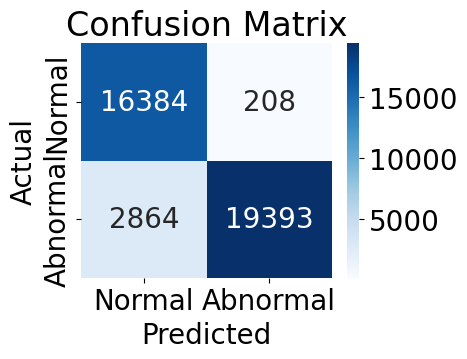

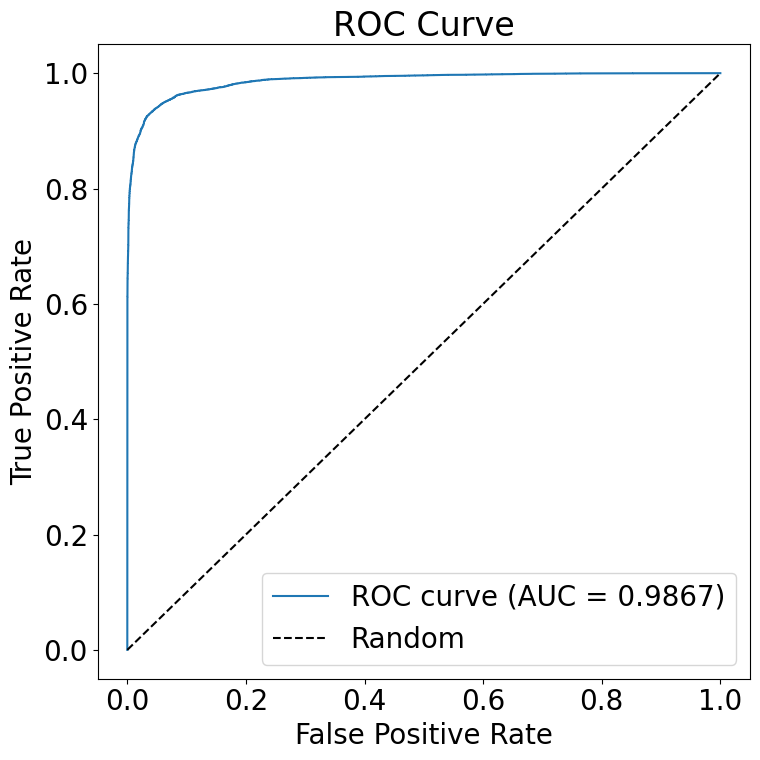

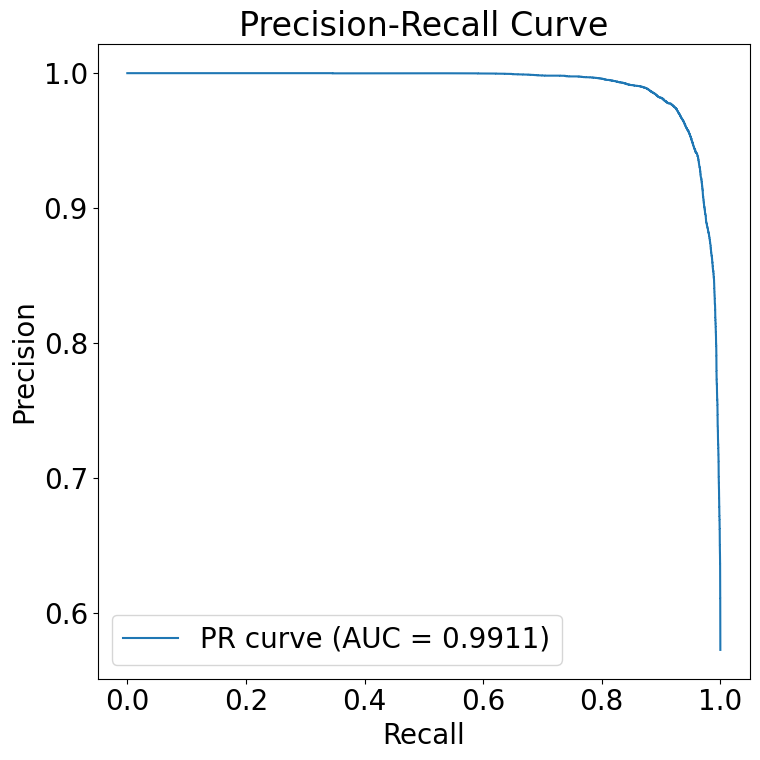

In [37]:
all_preds, all_labels, all_probs= evaluate_model(model, test_loader, device, threshold=0.85)

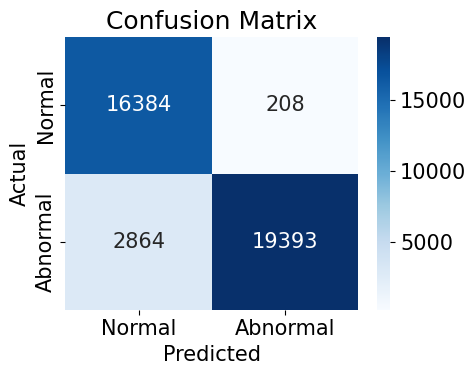

In [ ]:
#confusion matrix 만 그림 다시 그림
cm = confusion_matrix(all_labels, all_preds)


plt.rc('font', size=15)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Normal", "Abnormal"], yticklabels=["Normal", "Abnormal"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
